<a href="https://colab.research.google.com/github/Snapchik/chat_analysis/blob/main/Chats_copmparisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming

In [3]:
# download the stopwords from NLTK
nltk.download('stopwords')

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
hammas_chat = pd.read_json('/content/drive/My Drive/Colab Notebooks/result.json')

# extracts date and text from a dictionary under similar key
hammas_chat_normalized = pd.json_normalize(hammas_chat['messages'])

hammas_chat_normalized_dropped = hammas_chat_normalized.drop(columns=['id', 'type','date_unixtime', 'actor', 'actor_id', 'action',
       'title', 'edited', 'edited_unixtime', 'from',
       'from_id', 'message_id', 'file', 'thumbnail', 'media_type', 'mime_type',
       'duration_seconds', 'width', 'height', 'photo', 'reply_to_message_id',
       'forwarded_from', 'performer', 'poll.question', 'poll.closed',
       'poll.total_voters', 'poll.answers','text_entities'])
hammas_chat_normalized_dropped = hammas_chat_normalized_dropped.replace('', np.nan).dropna(subset = ['text'])
hammas_chat_normalized_dropped['date']= pd.to_datetime(hammas_chat_normalized_dropped['date'])

def extract_hashtags(messages):
    try:
        return re.findall(r'#(\w+)', str(messages))[0]
    except IndexError as err:
        return np.nan


hammas_chat_normalized_dropped['hashtags'] = hammas_chat_normalized_dropped['text'].apply(extract_hashtags)

def extract_text(row):
  """Extracts text from a list nested with dictionary.

  Args:
    row: a row of the dataframe.

  Returns:
    A string of the text.
  """
  lst = []
  for i in row[1]:
    try:
      lst.extend(i.values())
    except AttributeError as err:
      lst.extend(i)
  lst = ''.join(lst)
  #getting rid of typetext/n
  typetext = '\w+'
  re.sub(typetext,'', lst)
  return lst

# apply the function to all rows
hammas_chat_normalized_dropped['extracted_text'] = hammas_chat_normalized_dropped.apply(extract_text, axis=1)


In [60]:
#Big preprocessing steps

#clearing out some common misspellings and hyperlink
hammas_chat_normalized_dropped['extracted_text'] = hammas_chat_normalized_dropped['extracted_text'].str.replace('\n', '')
hammas_chat_normalized_dropped['extracted_text'] = hammas_chat_normalized_dropped['extracted_text'].str.replace('text_link', '')
hammas_chat_normalized_dropped['extracted_text'] = hammas_chat_normalized_dropped['extracted_text'].str.replace(r'https?://[^\s\n\r]+', '', regex=True)
hammas_chat_normalized_dropped['extracted_text'] = hammas_chat_normalized_dropped['extracted_text'].str.replace(r'bold\B', '', regex=True)
hammas_chat_normalized_dropped['extracted_text'] = hammas_chat_normalized_dropped['extracted_text'].str.replace(r'#', '',regex=True)
hammas_chat_normalized_dropped['extracted_text'] = hammas_chat_normalized_dropped['extracted_text'].str.replace('hashtag', '')
hammas_chat_normalized_dropped['extracted_text'] = hammas_chat_normalized_dropped['extracted_text'].str.replace('italic', '')
hammas_chat_normalized_dropped['extracted_text'] = hammas_chat_normalized_dropped['extracted_text'].str.replace('_', '')
hammas_chat_normalized_dropped['extracted_text'] = hammas_chat_normalized_dropped['extracted_text'].str.replace('—', '')

#applying tokenizer
hammas_chat_normalized_dropped['messages_token'] = hammas_chat_normalized_dropped["extracted_text"].apply(nltk.word_tokenize)

#removing stop words
stopwords_english = stopwords.words('english')

hammas_chat_normalized_dropped['tokens_without_stopwords'] = hammas_chat_normalized_dropped['messages_token'].apply(lambda x:
    [word for word in x if word not in (stopwords_english) and word not in string.punctuation])


# Instantiate stemming class
stemmer = PorterStemmer()

hammas_chat_normalized_dropped['stemmed_tokens_wt_stopwords_punctuation'] = hammas_chat_normalized_dropped['tokens_without_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

hammas_chat_normalized_dropped['stemmed_tokens_wt_stopwords_punctuation']

2        [welcom, joint, channel, creat, order, deliv, ...
4        [coloni, occup, forc, fire, tear, ga, youth, b...
5        [young, men, shuafat, shave, head, attempt, co...
6        [yesterday, pa, forc, arrest, ana, qafisha, mi...
7        [the, lionsden, nablu, releas, statement, toda...
                               ...                        
30366    [🚨, humanitarian, aid, airdrop, jordanian, pla...
30367    [🔴, martyr, abu, ali, mustafa, brigad, the, ma...
30368    [🔴, popular, front, liber, palestin, on, step,...
30369    [⚪️, mujahideen, brigad, in, respons, corrupt,...
30370    [🚨, palestinian, ministri, health, the, toll, ...
Name: stemmed_tokens_wt_stopwords_punctuation, Length: 25566, dtype: object

In [61]:
hammas_chat_normalized_dropped

,date,text,hashtags,extracted_text,messages_token,tokens_without_stopwords,stemmed_tokens_wt_stopwords_punctuation
2,2022-10-15 23:37:11,"Welcome, this is a joint channel created in or...",NaN,"Welcome, this is a joint channel created in or...","[Welcome, ,, this, is, a, joint, channel, crea...","[Welcome, joint, channel, created, order, deli...","[welcom, joint, channel, creat, order, deliv, ..."
4,2022-10-15 23:42:48,Colonial occupation forces fire tear gas as th...,NaN,Colonial occupation forces fire tear gas as th...,"[Colonial, occupation, forces, fire, tear, gas...","[Colonial, occupation, forces, fire, tear, gas...","[coloni, occup, forc, fire, tear, ga, youth, b..."
5,2022-10-15 23:49:42,[Young men from Shuafat shave their heads in a...,NaN,Young men from Shuafat shave their heads in an...,"[Young, men, from, Shuafat, shave, their, head...","[Young, men, Shuafat, shave, heads, attempt, c...","[young, men, shuafat, shave, head, attempt, co..."
6,2022-10-15 23:58:49,"Yesterday, PA forces arrested Anas Qafisha and...",NaN,"Yesterday, PA forces arrested Anas Qafisha and...","[Yesterday, ,, PA, forces, arrested, Anas, Qaf...","[Yesterday, PA, forces, arrested, Anas, Qafish...","[yesterday, pa, forc, arrest, ana, qafisha, mi..."
7,2022-10-16 00:10:51,"[The , {'type': 'hashtag', 'text': '#LionsDen'...",LionsDen,The LionsDen of Nablus released a statement to...,"[The, LionsDen, of, Nablus, released, a, state...","[The, LionsDen, Nablus, released, statement, t...","[the, lionsden, nablu, releas, statement, toda..."
...,...,...,...,...,...,...,...
30366,2024-02-29 17:55:28,🚨 Humanitarian aid airdropped by Jordanian pla...,NaN,🚨 Humanitarian aid airdropped by Jordanian pla...,"[🚨, Humanitarian, aid, airdropped, by, Jordani...","[🚨, Humanitarian, aid, airdropped, Jordanian, ...","[🚨, humanitarian, aid, airdrop, jordanian, pla..."
30367,2024-02-29 18:01:05,[🔴 Martyr Abu Ali Mustafa Brigades:\n—\nThe Ma...,NaN,🔴 Martyr Abu Ali Mustafa Brigades:The Martyr A...,"[🔴, Martyr, Abu, Ali, Mustafa, Brigades, :, Th...","[🔴, Martyr, Abu, Ali, Mustafa, Brigades, The, ...","[🔴, martyr, abu, ali, mustafa, brigad, the, ma..."
30368,2024-02-29 18:02:31,[🔴 Popular Front for the Liberation of Palesti...,NaN,🔴 Popular Front for the Liberation of Palestin...,"[🔴, Popular, Front, for, the, Liberation, of, ...","[🔴, Popular, Front, Liberation, Palestine, On,...","[🔴, popular, front, liber, palestin, on, step,..."
30369,2024-02-29 18:05:37,⚪️ Mujahideen Brigades: \n—\nIn response to th...,NaN,⚪️ Mujahideen Brigades: In response to the cor...,"[⚪️, Mujahideen, Brigades, :, In, response, to...","[⚪️, Mujahideen, Brigades, In, response, corru...","[⚪️, mujahideen, brigad, in, respons, corrupt,..."


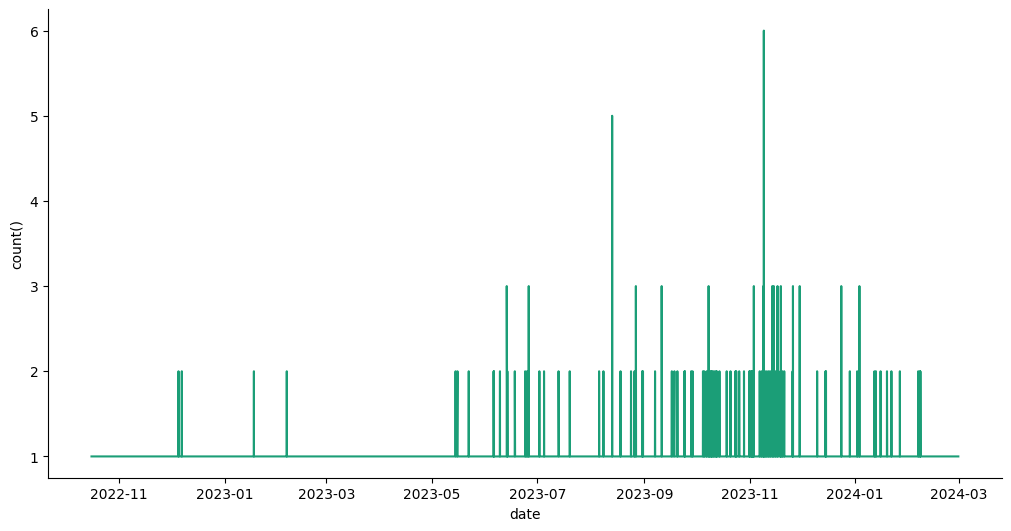

In [52]:
# @title date vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = hammas_chat_normalized_dropped.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

In [67]:
IDF_chat = pd.read_json('/content/drive/My Drive/Colab Notebooks/IDF.json')

# extracts date and text from a dictionary under similar key
IDF_chat_normalized = pd.json_normalize(IDF_chat['messages'])

IDF_chat_normalized_dropped = IDF_chat_normalized.drop(columns=['id', 'type','date_unixtime', 'actor', 'actor_id', 'action',
       'title', 'edited', 'edited_unixtime', 'from',
       'from_id', 'file', 'thumbnail', 'media_type', 'mime_type',
       'duration_seconds', 'width', 'height', 'photo', 'reply_to_message_id',
       'text_entities', 'duration', 'file_name'])
IDF_chat_normalized_dropped = IDF_chat_normalized_dropped.replace('', np.nan).dropna(subset = ['text'])
IDF_chat_normalized_dropped['date']= pd.to_datetime(IDF_chat_normalized_dropped['date'])

# def extract_hashtags(messages):
#     try:
#         return re.findall(r'#(\w+)', str(messages))[0]
#     except IndexError as err:
#         return np.nan


# IDF_chat_normalized_dropped['hashtags'] = IDF_chat_normalized_dropped['text'].apply(extract_hashtags)

def extract_text(row):
  """Extracts text from a list nested with dictionary.

  Args:
    row: a row of the dataframe.

  Returns:
    A string of the text.
  """
  lst = []
  for i in row[1]:
    try:
      lst.extend(i.values())
    except AttributeError as err:
      lst.extend(i)
  lst = ''.join(lst)
  #getting rid of typetext/n
  typetext = '\w+'
  re.sub(typetext,'', lst)
  return lst

# apply the function to all rows
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped.apply(extract_text, axis=1)


In [71]:
#Big preprocessing steps

#clearing out some common misspellings and hyperlink
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped['extracted_text'].str.replace('\n', '')
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped['extracted_text'].str.replace('text_link', '')
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped['extracted_text'].str.replace(r'https?://[^\s\n\r]+', '', regex=True)
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped['extracted_text'].str.replace(r'bold\B', '', regex=True)
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped['extracted_text'].str.replace(r'#', '',regex=True)
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped['extracted_text'].str.replace('hashtag', '')
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped['extracted_text'].str.replace('italic', '')
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped['extracted_text'].str.replace('_', '')
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped['extracted_text'].str.replace('—', '')
IDF_chat_normalized_dropped['extracted_text'] = IDF_chat_normalized_dropped['extracted_text'].str.replace('-', '')


#applying tokenizer
IDF_chat_normalized_dropped['messages_token'] = IDF_chat_normalized_dropped["extracted_text"].apply(nltk.word_tokenize)

#removing stop words
stopwords_english = stopwords.words('english')

IDF_chat_normalized_dropped['tokens_without_stopwords'] = IDF_chat_normalized_dropped['messages_token'].apply(lambda x:
    [word for word in x if word not in (stopwords_english) and word not in string.punctuation])


# Instantiate stemming class
stemmer = PorterStemmer()

IDF_chat_normalized_dropped['stemmed_tokens_wt_stopwords_punctuation'] = IDF_chat_normalized_dropped['tokens_without_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

IDF_chat_normalized_dropped['stemmed_tokens_wt_stopwords_punctuation']

1       [idf, pleas, find, attach, follow, idf, announ...
2       [idf, initi, report, siren, sound, kibbutz, ni...
3       [idf, follow, previou, report, regard, siren, ...
4       [idf, pleas, find, attach, follow, idf, announ...
5       [idf, a, short, ago, one, projectil, fire, gaz...
                              ...                        
8227    [idf, siren, sound, kibbutz, bar'am, northern,...
8228    [idf, locat, readytous, launcher, near, border...
8229    [idf, a, short, ago, number, launch, identifi,...
8230    [idf, a, signific, tunnel, use, terrorist, for...
8231    [idf, siren, sound, arab, alaramsh, northern, ...
Name: stemmed_tokens_wt_stopwords_punctuation, Length: 8226, dtype: object

In [72]:
IDF_chat_normalized_dropped

,date,text,extracted_text,messages_token,tokens_without_stopwords,stemmed_tokens_wt_stopwords_punctuation
1,2020-01-22 23:20:32,[IDF: Please find attached the following IDF a...,IDF: Please find attached the following IDF an...,"[IDF, :, Please, find, attached, the, followin...","[IDF, Please, find, attached, following, IDF, ...","[idf, pleas, find, attach, follow, idf, announ..."
2,2020-01-23 21:18:47,IDF: Initial report- Sirens sounded in Kibbutz...,IDF: Initial report Sirens sounded in Kibbutz ...,"[IDF, :, Initial, report, Sirens, sounded, in,...","[IDF, Initial, report, Sirens, sounded, Kibbut...","[idf, initi, report, siren, sound, kibbutz, ni..."
3,2020-01-23 22:14:41,IDF: Following the previous report regarding s...,IDF: Following the previous report regarding s...,"[IDF, :, Following, the, previous, report, reg...","[IDF, Following, previous, report, regarding, ...","[idf, follow, previou, report, regard, siren, ..."
4,2020-01-26 01:04:47,[IDF: Please find attached the following IDF a...,IDF: Please find attached the following IDF an...,"[IDF, :, Please, find, attached, the, followin...","[IDF, Please, find, attached, following, IDF, ...","[idf, pleas, find, attach, follow, idf, announ..."
5,2020-01-26 19:51:18,"IDF: A short while ago, one projectile was fir...","IDF: A short while ago, one projectile was fir...","[IDF, :, A, short, while, ago, ,, one, project...","[IDF, A, short, ago, one, projectile, fired, G...","[idf, a, short, ago, one, projectil, fire, gaz..."
...,...,...,...,...,...,...
8227,2024-06-05 17:53:06,"IDF: Sirens sounded in Kibbutz Bar'am, norther...","IDF: Sirens sounded in Kibbutz Bar'am, norther...","[IDF, :, Sirens, sounded, in, Kibbutz, Bar'am,...","[IDF, Sirens, sounded, Kibbutz, Bar'am, northe...","[idf, siren, sound, kibbutz, bar'am, northern,..."
8228,2024-06-05 18:12:12,"[IDF: , {'type': 'bold', 'text': 'Locating a R...",IDF: Locating a ReadytoUse Launcher Near the B...,"[IDF, :, Locating, a, ReadytoUse, Launcher, Ne...","[IDF, Locating, ReadytoUse, Launcher, Near, Bo...","[idf, locat, readytous, launcher, near, border..."
8229,2024-06-05 18:45:29,"IDF: A short while ago, a number of launches t...","IDF: A short while ago, a number of launches t...","[IDF, :, A, short, while, ago, ,, a, number, o...","[IDF, A, short, ago, number, launches, identif...","[idf, a, short, ago, number, launch, identifi,..."
8230,2024-06-05 19:01:37,"[IDF: , {'type': 'bold', 'text': 'A Significan...",IDF: A Significant Tunnel that was used by Ter...,"[IDF, :, A, Significant, Tunnel, that, was, us...","[IDF, A, Significant, Tunnel, used, Terrorists...","[idf, a, signific, tunnel, use, terrorist, for..."


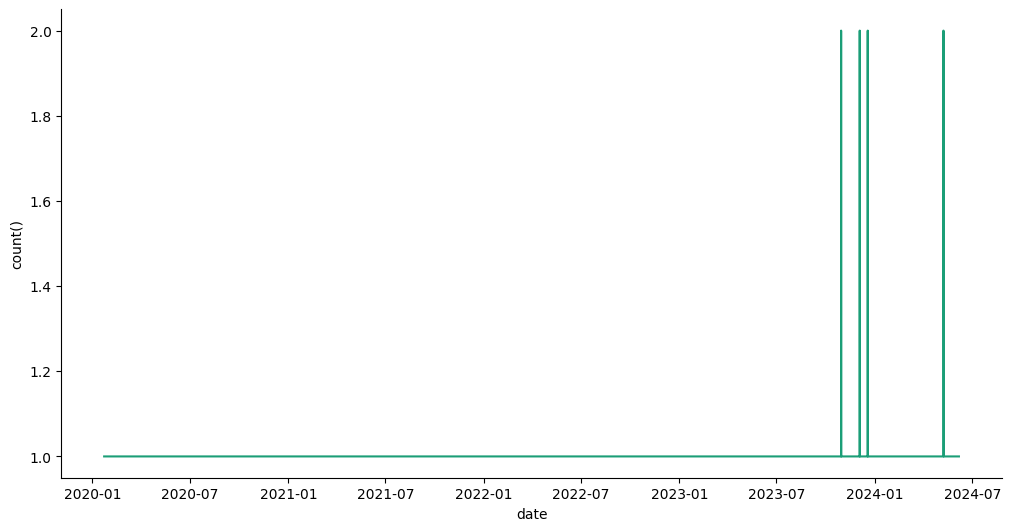

In [73]:
# @title date vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = IDF_chat_normalized_dropped.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

In [50]:
hammas_chat = pd.read_json('/content/drive/My Drive/Colab Notebooks/result.json')

hammas_chat['hashtags'] = [[] for _ in range(len(hammas_chat))]
hammas_chat['date'] = [[] for _ in range(len(hammas_chat))]
hammas_chat['clear_message'] = [[] for _ in range(len(hammas_chat))]

def extract_hashtags(messages):
    try:
        return re.findall(r'#(\w+)', str(messages))[0]
    except IndexError as err:
        return np.nan


hammas_chat['hashtags'] = hammas_chat['messages'].apply(extract_hashtags)

message_count = len(hammas_chat['messages'])

for index in range(message_count):
  hammas_chat['date'][index] = pd.to_datetime(hammas_chat.iloc[index, 3]['date'])

for index in range(message_count):
  hammas_chat['clear_message'][index] = hammas_chat.iloc[index, 3]['text']


hammas_chat = hammas_chat.drop(columns=['name', 'type', 'id'])
hammas_chat = hammas_chat.replace('', np.nan)
hammas_chat = hammas_chat.apply(lambda y: np.nan if len(y)==0 else y)
hammas_chat = hammas_chat.dropna(subset = ['clear_message'])

KeyboardInterrupt: 

In [38]:
hammas_chat['text']

0        idtypedatedate_unixtimeactoractor_idactiontitl...
1        idtypedatedate_unixtimeactoractor_idactiontitl...
2        idtypedatedate_unixtimeeditededited_unixtimefr...
3        idtypedatedate_unixtimeactoractor_idactionmess...
4        idtypedatedate_unixtimeeditededited_unixtimefr...
                               ...                        
30366    idtypedatedate_unixtimeeditededited_unixtimefr...
30367    idtypedatedate_unixtimeeditededited_unixtimefr...
30368    idtypedatedate_unixtimeeditededited_unixtimefr...
30369    idtypedatedate_unixtimeeditededited_unixtimefr...
30370    idtypedatedate_unixtimeeditededited_unixtimefr...
Name: text, Length: 30371, dtype: object

In [17]:
# WHY THIS CODE WORKS AND NOT THE ONE ON TOP
for j in range(len(hammas_chat)):
  lst = []
  for i in hammas_chat.iloc[j, 3]:
    try:
      lst.extend(i.values())
    except AttributeError as err:
      lst.extend(i)
  lst = ''.join(lst)
  #getting rid of typetext/n
  typetext = '\w+\n'
  re.sub(typetext,'', lst)
  hammas_chat.iloc[j, 3] = lst

In [28]:
#Big preprocessing steps

#clearing out some common misspellings and hyperlink
hammas_chat['clear_message'] = hammas_chat['clear_message'].str.replace('\n', '')
hammas_chat['clear_message'] = hammas_chat['clear_message'].str.replace('text_link', '')
hammas_chat['clear_message'] = hammas_chat['clear_message'].str.replace(r'https?://[^\s\n\r]+', '', regex=True)
hammas_chat['clear_message'] = hammas_chat['clear_message'].str.replace(r'bold\B', '', regex=True)
hammas_chat['clear_message'] = hammas_chat['clear_message'].str.replace(r'#', '',regex=True)
hammas_chat['clear_message'] = hammas_chat['clear_message'].str.replace('hashtag', '')
hammas_chat['clear_message'] = hammas_chat['clear_message'].str.replace('italic', '')
hammas_chat['clear_message'] = hammas_chat['clear_message'].str.replace('_', '')
hammas_chat['clear_message'] = hammas_chat['clear_message'].str.replace('—', '')

#applying tokenizer
hammas_chat['messages_token'] = hammas_chat["clear_message"].apply(nltk.word_tokenize)

#removing stop words
stopwords_english = stopwords.words('english')

hammas_chat['tokens_without_stopwords'] = hammas_chat['messages_token'].apply(lambda x:
    [word for word in x if word not in (stopwords_english) and word not in string.punctuation])


# Instantiate stemming class
stemmer = PorterStemmer()

hammas_chat['stemmed_tokens_wt_stopwords_punctuation'] = hammas_chat['tokens_without_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

print(hammas_chat['stemmed_tokens_wt_stopwords_punctuation'])

2        [welcom, joint, channel, creat, order, deliv, ...
4        [coloni, occup, forc, fire, tear, ga, youth, b...
5        [young, men, shuafat, shave, head, attempt, co...
6        [yesterday, pa, forc, arrest, ana, qafisha, mi...
7        [the, lionsden, nablu, releas, statement, toda...
                               ...                        
30366    [🚨, humanitarian, aid, airdrop, jordanian, pla...
30367    [🔴, martyr, abu, ali, mustafa, brigad, the, ma...
30368    [🔴, popular, front, liber, palestin, on, step,...
30369    [⚪️, mujahideen, brigad, in, respons, corrupt,...
30370    [🚨, palestinian, ministri, health, the, toll, ...
Name: stemmed_tokens_wt_stopwords_punctuation, Length: 25566, dtype: object


Next up I need to create a util package like in lab